# Example Workflow with synthesizAR

In [147]:
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import ConnectionPatch
import seaborn
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from sunpy.coordinates import HeliographicStonyhurst, Helioprojective
from sunpy.net import Fido, attrs, vso
from sunpy.map import Map,GenericMap
from sunpy.time import TimeRange
import synthesizAR
import synthesizAR.extrapolate
import yt
import pfsspy
from synthesizAR.visualize import plot_fieldlines
import astropy.time
from astropy.visualization import LogStretch,ImageNormalize,SqrtStretch,AsinhStretch
from synthesizAR.interfaces import MartensInterface
import fiasco
from synthesizAR.atomic import EmissionModel
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.util import SpatialPair

%matplotlib inline

In [2]:
better_rdbu = matplotlib.colors.LinearSegmentedColormap.from_list(
    'better_RdBu',
    [seaborn.color_palette('deep')[3], 'w', seaborn.color_palette('deep')[0]])
matplotlib.cm.register_cmap(name=better_rdbu.name, cmap=better_rdbu)
better_rdbu_r = matplotlib.colors.LinearSegmentedColormap.from_list(
    'better_RdBu_r',
    [seaborn.color_palette('deep')[0], 'w', seaborn.color_palette('deep')[3]])
matplotlib.cm.register_cmap(name=better_rdbu_r.name, cmap=better_rdbu_r)

First, download the magnetogram

In [ ]:
q = Fido.search(
    attrs.Time(TimeRange('2019/01/24 14:00:00', 1*u.min)),
    attrs.Instrument('HMI'),
    vso.attrs.Physobs('LOS_magnetic_field')
)

In [43]:
#file = Fido.fetch(q)
file = '/Users/willbarnes/sunpy/data/hmi_m_45s_2019_01_24_14_01_30_tai_magnetogram.fits'

In [44]:
magnetogram = Map(file).rotate(order=3)
#magnetogram = magnetogram.submap(
#    SkyCoord(Tx=-142*u.arcsec,Ty=50*u.arcsec,frame=magnetogram.coordinate_frame),
#    SkyCoord(Tx=158*u.arcsec,Ty=350*u.arcsec,frame=magnetogram.coordinate_frame)
#)

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/sunpy/map/mapbase.py:670: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/sunpy/map/mapbase.py:670: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


In [45]:
l_corner = SkyCoord(Tx=-142*u.arcsec,Ty=50*u.arcsec,frame=magnetogram.coordinate_frame)
r_corner = SkyCoord(Tx=158*u.arcsec,Ty=350*u.arcsec,frame=magnetogram.coordinate_frame)
# Mask off limb

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/sunpy/map/mapbase.py:670: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/sunpy/map/mapbase.py:670: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/sunpy/map/mapbase.py:670: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/sit

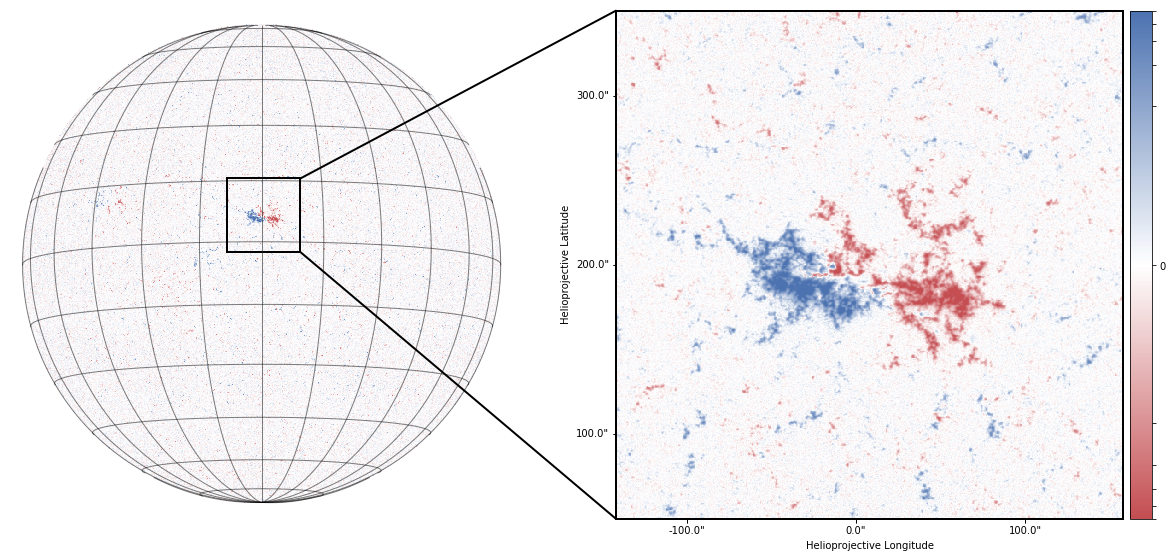

In [46]:
fig = plt.figure(figsize=(20,10))
x, y = np.meshgrid(*[np.arange(v.value) for v in magnetogram.dimensions]) * u.pixel
hpc_coords = magnetogram.pixel_to_world(x, y)
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / magnetogram.rsun_obs
mask = np.ma.masked_greater(r, 1)
m_big = Map(magnetogram.data, magnetogram.meta, mask=mask.mask)
norm = matplotlib.colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)#ImageNormalize(vmin=-7.5e2,vmax=7.5e2,stretch=LogStretch())
# Plot
ax1 = fig.add_subplot(121,projection=m_big)
m_big.plot(
    axes=ax1,
    cmap='better_RdBu',
    norm=norm,
    annotate=False,
    title=False,
)
lon,lat = ax1.coords[0],ax1.coords[1]
lon.frame.set_linewidth(0)
lat.frame.set_linewidth(0)
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)
lon.set_ticklabel_visible(False)
lat.set_ticklabel_visible(False)
m_big.draw_rectangle(l_corner, r_corner.Tx-l_corner.Tx, r_corner.Ty-l_corner.Ty, color='k',lw=2);
m_big.draw_grid(axes=ax1,color='k',alpha=0.5,lw=1)
# Zoom
m_small = magnetogram.submap(l_corner, r_corner)
ax2 = fig.add_subplot(122,projection=m_small)
im = m_small.plot(
    axes=ax2,
    norm=norm,
    cmap='better_RdBu',
    annotate=False,
)
lon,lat = ax2.coords[0],ax2.coords[1]
lon.frame.set_linewidth(2)
lat.frame.set_linewidth(2)
lon.set_axislabel('Helioprojective Longitude')
lat.set_axislabel('Helioprojective Latitude')
pos = ax2.get_position().get_points()
cax = fig.add_axes([
    pos[1,0]+0.005, pos[0,1], 0.015, pos[1,1]-pos[0,1]
])
cbar = fig.colorbar(im,cax=cax,orientation='vertical')
cbar.locator = matplotlib.ticker.MaxNLocator(nbins=10,)
cbar.update_ticks()

xpix,ypix = m_big.world_to_pixel(r_corner)
con1 = ConnectionPatch(
    (0,1),
    (xpix.value,ypix.value),
    'axes fraction','data',
    axesA=ax2, axesB=ax1,
    arrowstyle='-',
    color='k',
    lw=2
)
ax2.add_artist(con1)
xpix,ypix = m_big.world_to_pixel(
    SkyCoord(r_corner.Tx,l_corner.Ty,frame=m_big.coordinate_frame)
)
con2 = ConnectionPatch(
    (0,0),
    (xpix.value,ypix.value),
    'axes fraction','data',
    axesA=ax2, axesB=ax1,
    arrowstyle='-',
    color='k',
    lw=2
)
ax2.add_artist(con2)

In [47]:
magnetogram_ar = magnetogram.submap(l_corner,r_corner)

In [48]:
magnetogram_resample = magnetogram_ar.resample([100,100]*u.pixel)

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/sunpy/map/mapbase.py:670: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


In [8]:
shape_z = 100 * u.pixel
width_z = ((magnetogram_resample.scale.axis1 * shape_z).to(u.radian).value 
           * magnetogram_resample.dsun)

In [9]:
extrapolator = synthesizAR.extrapolate.PotentialField(magnetogram_resample, width_z, shape_z)
B_field = extrapolator.extrapolate()

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/sunpy/map/mapbase.py:670: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


In [10]:
lines = extrapolator.trace_fieldlines(
    B_field,
    200,
)

yt : [INFO     ] 2019-02-16 21:22:57,914 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-02-16 21:22:57,915 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2019-02-16 21:22:57,915 Parameters: domain_left_edge          = [-1.06505273e+10 -1.05724643e+10  0.00000000e+00]
yt : [INFO     ] 2019-02-16 21:22:57,916 Parameters: domain_right_edge         = [1.06890942e+10 1.12944103e+10 2.14086290e+10]
yt : [INFO     ] 2019-02-16 21:22:57,918 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-02-16 21:22:58,757 AMRKDTree rebuilt, Final Volume: 9.989926e+30
Streamlining: 100%|██████████| 200/200 [00:00<00:00, 467.44it/s]
yt : [INFO     ] 2019-02-16 21:22:59,945 AMRKDTree rebuilt, Final Volume: 9.989926e+30
Streamlining: 100%|██████████| 74/74 [00:00<00:00, 348.42it/s]
yt : [INFO     ] 2019-02-16 21:23:00,721 AMRKDTree rebuilt, Final Volume: 9.989926e+30
Streamlining: 100%|██████████| 29/29 [00:00<00:00, 379.50it/s]
yt : [INFO     ] 2019-02

FloatProgress(value=0.0)

In [11]:
ar = synthesizAR.Field(magnetogram_resample, lines)

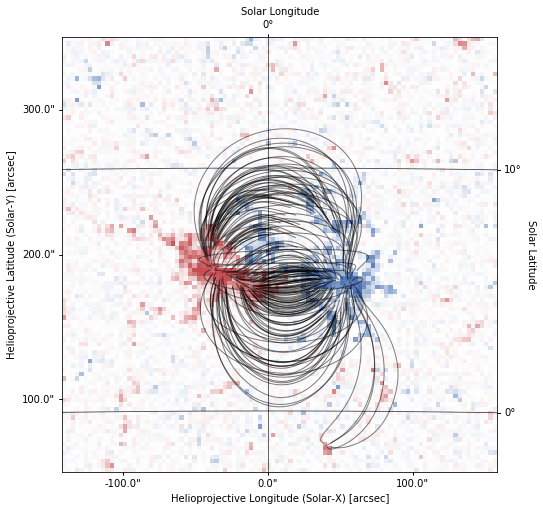

In [13]:
ar.peek(
    line_frequency=1,
    cmap='better_RdBu_r',
    norm=matplotlib.colors.SymLogNorm(50,vmin=-7.5e2,vmax=7.5e2)
)

In [93]:
martens = MartensInterface()

In [121]:
ar.load_loop_simulations(martens,'loop_results.h5')

FloatProgress(value=0.0)

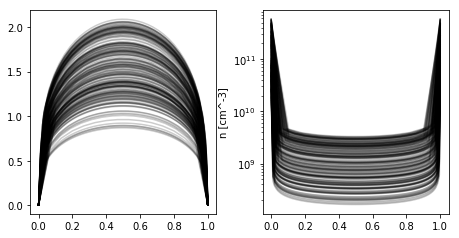

In [111]:
fig = plt.figure(figsize=(7.5,3.75))
ax1 = fig.add_subplot(121,)
ax2 = fig.add_subplot(122,)
for l in ar.loops:
    ax1.plot(l.field_aligned_coordinate/l.full_length,
             l.electron_temperature.to(u.MK)[0,:],color='k',alpha=0.2)
    ax2.plot(l.field_aligned_coordinate/l.full_length,
             l.density[0,:],color='k',alpha=0.2)
ax2.set_yscale('log')
ax2.set_ylabel('n [cm^-3]')
plt.subplots_adjust(wspace=0.25)

In [122]:
ar.save(savedir='checkpoint')

In [2]:
ar = synthesizAR.Field.restore('checkpoint',)

Next, compute the emission from a selected set of ions using the emission model

In [29]:
T = np.logspace(4, 8, 80) * u.K
kws = { 'abundance_filename': 'sun_coronal_1992_feldman' }
ions = [
    fiasco.Ion('Fe 8', T, **kws),
    fiasco.Ion('Fe 14', T, **kws),
    fiasco.Ion('Fe 16', T, **kws),
    fiasco.Ion('Fe 18', T, **kws),
]
n = np.logspace(8, 11, 15) * u.cm**(-3)
em_model = EmissionModel(n, *ions)

In [30]:
em_model.calculate_ionization_fraction(ar,'ionization_fractions.h5')

FloatProgress(value=0.0)

(0.001, 1)

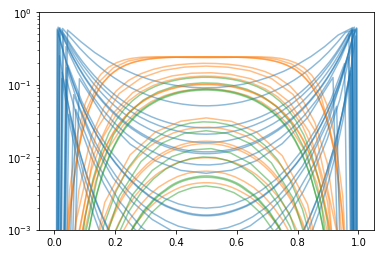

In [31]:
for l in ar.loops[::10]:
    for i in range(4):
        ionfrac = em_model.get_ionization_fraction(l, em_model[i])
        plt.plot(l.field_aligned_coordinate/l.full_length, ionfrac[0,:], color=f'C{i}', alpha=0.5)
plt.yscale('log')
plt.ylim(1e-3,1)

In [32]:
em_model.calculate_emissivity('emissivity_table.h5')

FloatProgress(value=0.0)

In [114]:
em_model.save('em_model.json')

In [3]:
em_model = EmissionModel.restore('em_model.json')

In [139]:
aia = InstrumentSDOAIA([0,1]*u.s, ar.magnetogram.observer_coordinate)

In [140]:
observer = synthesizAR.Observer(ar, [aia],)

In [141]:
observer.build_detector_files('.', 0.05*u.Mm)

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [64]:
observer.flatten_detector_counts(emission_model=em_model)

In [65]:
observer.bin_detector_counts('.')

In [63]:
aia.counts_file

'./SDO_AIA_counts.h5'

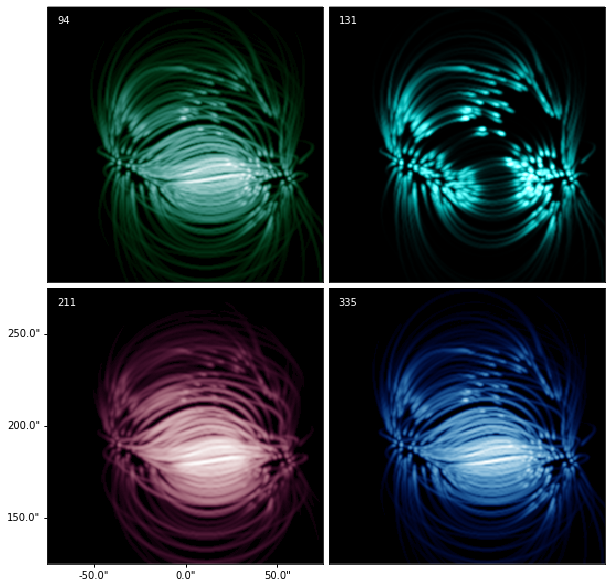

In [66]:
fig = plt.figure(figsize=(10,10.25))
for i,c in enumerate([94,131,211,335]):
    m = Map(f'SDO_AIA/{c}/map_t000000.fits')
    m = m.submap(
        SkyCoord(*[-75,125]*u.arcsec, frame=m.coordinate_frame),
        SkyCoord(*[75,275]*u.arcsec, frame=m.coordinate_frame)
    )
    ax = fig.add_subplot(2,2,i+1,projection=m)
    m.plot(axes=ax,annotate=False,norm=ImageNormalize(vmin=0,vmax=m.data.max(),stretch=AsinhStretch(0.01)))
    lon,lat = ax.coords[0],ax.coords[1]
    if i != 2:
        lon.set_ticks_visible(False)
        lat.set_ticks_visible(False)
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
    ax.grid(alpha=0)
    xt,yt = m.world_to_pixel(SkyCoord(*[-70,270]*u.arcsec,frame=m.coordinate_frame))
    ax.text(xt.value, yt.value, f'{c}', verticalalignment='top',horizontalalignment='left',color='w')
plt.subplots_adjust(wspace=0.02,hspace=0.02)

In [108]:
aia = InstrumentSDOAIA([0,1]*u.s, SkyCoord(lon=ar.magnetogram.center.transform_to('heliographic_stonyhurst').lon - 90*u.deg,
                                           lat=ar.magnetogram.observer_coordinate.lat,
                                           radius=ar.magnetogram.observer_coordinate.radius,
                                           frame='heliographic_stonyhurst'))
observer = synthesizAR.Observer(ar, [aia],)
observer.build_detector_files('.', 0.05*u.Mm)

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [109]:
observer.bin_detector_counts('.')

In [ ]:
m.

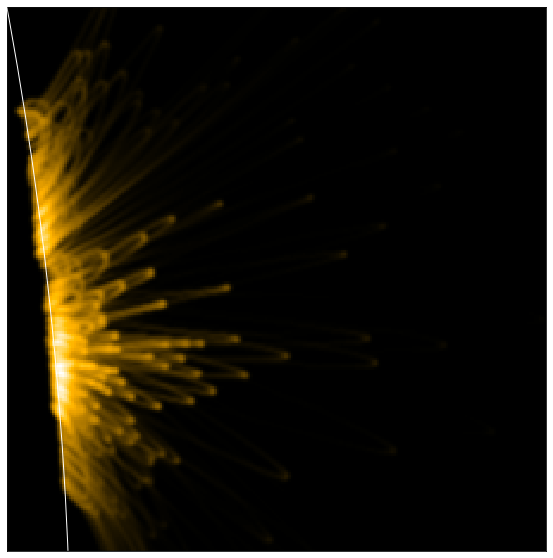

In [274]:
fig = plt.figure(figsize=(10,10))
for i,c in enumerate([
    #94,
    171,
    #211,
    #335
]):
    m = Map(f'SDO_AIA/{c}/map_t000000.fits')
    w = m.top_right_coord.Tx - m.bottom_left_coord.Tx
    m = m.submap(
        SkyCoord(Tx=m.bottom_left_coord.Tx,Ty=m.center.Ty-w/2,frame=m.center.frame),
        SkyCoord(Tx=m.top_right_coord.Tx,Ty=m.center.Ty+w/2,frame=m.center.frame)
    )
    ax = fig.add_subplot(1,1,i+1,projection=m)
    m.plot(axes=ax,annotate=False,norm=ImageNormalize(vmin=0,vmax=m.data.max(),stretch=AsinhStretch(1e-2)))
    lon,lat = ax.coords[0],ax.coords[1]
    if i != 2:
        lon.set_ticks_visible(False)
        lat.set_ticks_visible(False)
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
    ax.grid(alpha=0)
    m.draw_limb(color='w')
    #m.draw_grid(color='w',grid_spacing=5*u.deg)
    #ax.plot_coord(
    #    SkyCoord(Tx=m.bottom_left_coord.Tx-75*u.arcsec,Ty=m.center.Ty-75*u.arcsec,frame=m.center.frame),
    #    color='k',alpha=0,
    #)
    #ax.plot_coord(
    #    SkyCoord(Tx=m.bottom_left_coord.Tx+75*u.arcsec,Ty=m.center.Ty+75*u.arcsec,frame=m.center.frame),
    #    color='k',alpha=0,
    #)
    ax.set_facecolor('k')
plt.subplots_adjust(wspace=0.02,hspace=0.02)

In [275]:
Lfull = [l.full_length.value for l in ar.loops]
i_long = np.argsort(Lfull)[::-1]

In [296]:
resolution.y

<Quantity 20.14712881 arcsec / pix>

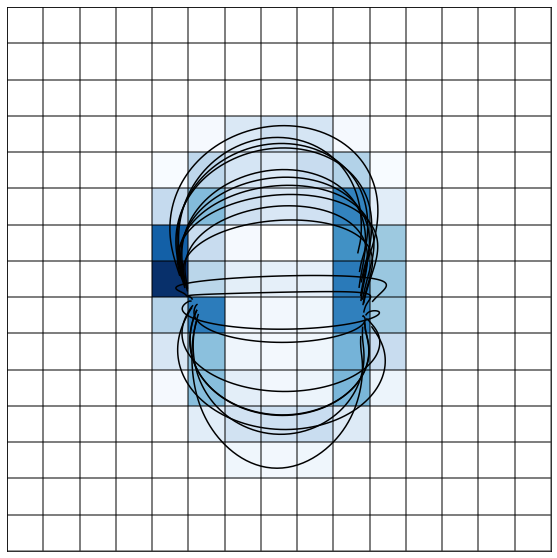

In [298]:
loop_list = [ar.loops[i] for i in i_long[:20]]
_bins,bin_range = aia.make_detector_array(ar)
bins = SpatialPair(x=15*u.pixel,
                   y=15*u.pixel,
                   z=None)
resolution = SpatialPair(x=((bin_range.x[1] - bin_range.x[0]) / bins.x),
                         y=((bin_range.y[1] - bin_range.y[0]) / bins.y),
                         z=None)
meta = aia.make_fits_header(ar, aia.channels[0])
meta['cdelt1'] = resolution.x.value
meta['cdelt2'] = resolution.y.value
meta['crpix1'] = (bins.x.value + 1.0)/2.0
meta['crpix2'] = (bins.y.value + 1.0)/2.0
x = np.hstack([l.coordinates.x.value for l in loop_list]) * u.cm
y = np.hstack([l.coordinates.y.value for l in loop_list]) * u.cm
z = np.hstack([l.coordinates.z.value for l in loop_list]) * u.cm
loop = SkyCoord(x=x,y=y,z=z,frame=HeliographicStonyhurst,representation_type='cartesian')
data, bin_edges_x, bin_edges_y = np.histogram2d(loop.transform_to(Helioprojective(observer=aia.observer_coordinate)).Tx.value,
                                                loop.transform_to(Helioprojective(observer=aia.observer_coordinate)).Ty.value,
                                                bins=(bins.x.value, bins.y.value),
                                                range=(bin_range.x.value, bin_range.y.value))
dummy_map = GenericMap(data.T,meta,mask=data.T<=0)
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=dummy_map)
dummy_map.plot(axes=ax,cmap='Blues',annotate=False,)
for l in loop_list:
    ax.plot_coord(l.coordinates.transform_to(dummy_map.coordinate_frame),color='k',ls='-',marker='')
lon,lat = ax.coords[0],ax.coords[1]
lon.grid(color='k',lw=2,ls='-',alpha=0.5)
lat.grid(color='k',lw=2,ls='-',alpha=0.5)
lon.set_ticks(values=bin_edges_x*u.arcsec)#spacing=dummy_map.scale.axis1*1*u.pix)
lat.set_ticks(values=bin_edges_y*u.arcsec)#spacing=dummy_map.scale.axis2*1*u.pix)
lon.set_ticklabel_visible(False)
lat.set_ticklabel_visible(False)
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)

In [265]:
_bins

SpatialPair(x=<Quantity 503. pix>, y=<Quantity 504. pix>, z=<Quantity 504. pix>)

In [244]:
xyz[0]

array([array([6.93812685e+10, 6.95623197e+10, 6.97402839e+10, 6.99175812e+10,
       7.00957861e+10, 7.02740895e+10, 7.04521393e+10, 7.06296363e+10,
       7.08066868e+10, 7.09830560e+10, 7.11588585e+10, 7.13339467e+10,
       7.15083391e+10, 7.16818985e+10, 7.18545142e+10, 7.20261224e+10,
       7.21965540e+10, 7.23657065e+10, 7.25333441e+10, 7.26993854e+10,
       7.28635319e+10, 7.30256714e+10, 7.31854554e+10, 7.33427508e+10,
       7.34972215e+10, 7.36486275e+10, 7.37966004e+10, 7.39408599e+10,
       7.40810322e+10, 7.42167409e+10, 7.43476035e+10, 7.44731611e+10,
       7.45930346e+10, 7.47066962e+10, 7.48137065e+10, 7.49135493e+10,
       7.50057104e+10, 7.50896683e+10, 7.51649337e+10, 7.52309595e+10,
       7.52872637e+10, 7.53334303e+10, 7.53690253e+10, 7.53936725e+10,
       7.54070886e+10, 7.54090718e+10, 7.53995110e+10, 7.53783960e+10,
       7.53458128e+10, 7.53019508e+10, 7.52470745e+10, 7.51815363e+10,
       7.51057916e+10, 7.50203368e+10, 7.49257178e+10, 7.48225367e+10,

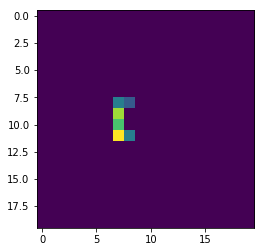

In [189]:
plt.imshow(data)

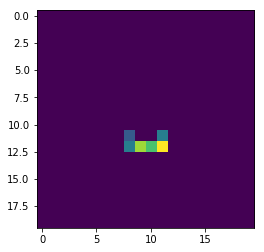

In [191]:
plt.imshow(np.flipud(data.T))

## PFSS Example

In [170]:
synmap_hmi = Map('/Users/willbarnes/Downloads/hmi.Synoptic_Mr.2212.fits')
#synmap.meta['CUNIT2'] = 'degree'
#synmap.meta['CDELT2'] = 180 / np.pi * synmap.meta['CDELT2']
#synmap.meta['CDELT1'] *= -1

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/sunpy/map/mapbase.py:812: Warning: Unknown value for CUNIT2
  Warning)


In [208]:
synmap = Map('/Users/willbarnes/Downloads/mrzqs190214t0014c2214_289.fits.gz')
synmap.meta['CUNIT1'] = 'degree'
synmap.meta['CUNIT2'] = 'degree'
synmap.meta['CDELT2'] = synmap.meta['CDELT2'] * 180/np.pi
#synmap.meta['CRPIX1'] = 180
synmap.meta['CRPIX2'] = 89.5
#synmap = synmap.submap(
#    SkyCoord(lon=synmap.bottom_left_coord.lon,lat=-80*u.deg,frame=synmap.coordinate_frame),
#    SkyCoord(lon=synmap.top_right_coord.lon,lat=80*u.deg,frame=synmap.coordinate_frame),
#)

In [209]:
synmap.top_right_coord

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic latitude: assuming Earth-based observer
  return SkyCoord(lat=self.heliographic_latitude,
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/sunpy/map/mapbase.py:670: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/sunpy/map/mapbase.py:671: Warning: Missing metadata for Sun-spacecraft separation: assuming Sun-Earth distance
  radius=self.dsun,


<SkyCoord (HeliographicCarrington: obstime=2019-02-14 00:00:00): (lon, lat, radius) in (deg, deg, km)
    (nan, nan, 695508.)>

In [207]:
print(synmap.pixel_to_world(0*u.pixel,0*u.pixel))
print(synmap.pixel_to_world(synmap.dimensions.x-0.5*u.pixel,synmap.dimensions.y-0.5*u.pixel))

<SkyCoord (HeliographicCarrington: obstime=2019-02-14 00:00:00): (lon, lat, radius) in (deg, deg, km)
    (nan, nan, 695508.)>
<SkyCoord (HeliographicCarrington: obstime=2019-02-14 00:00:00): (lon, lat, radius) in (deg, deg, km)
    (289., 81.45054004, 695508.)>


In [174]:
synmap.meta['CDELT2']*synmap.meta['naxis2']

114.59144443460562

In [177]:
(synmap.meta['naxis2'] - synmap.meta['crpix2'])*synmap.meta['CDELT2'] + synmap.meta['crval2']

56.977412649428906

In [179]:
synmap.meta['crval2'] - synmap.meta['crpix2']*synmap.meta['CDELT2']

-57.61403178517672

In [169]:
synmap.meta

MetaDict([('simple', True),
          ('bitpix', -32),
          ('naxis', 2),
          ('naxis1', 360),
          ('naxis2', 180),
          ('extend', False),
          ('origin', 'National Solar Observatory -- GONG'),
          ('obs-site', 'NSO/GONG NETWORK'),
          ('telescop', 'NSO-GONG'),
          ('obs-url', 'http://gong.nso.edu'),
          ('date', '2019-02-14T00:14:00'),
          ('date-obs', '2019-02-14'),
          ('time-obs', '00:14'),
          ('datatype', 'REAL*4'),
          ('wavelnth', 676.8),
          ('car_rot', 2214),
          ('wcsname', 'Carrington Cylin-equal-area'),
          ('ctype1', 'CRLN-CEA'),
          ('ctype2', 'CRLT-CEA'),
          ('crpix1', 180.5),
          ('crpix2', 90.5),
          ('crval1', 109),
          ('crval2', 0.0),
          ('pv2_1', 1.0),
          ('cdelt1', 1.0),
          ('cdelt2', 0.0111111),
          ('wcsnamea', 'Carrington-rotation Cylin-equal-area'),
          ('ctype1a', 'CRN-CEA'),
          ('ctype2a', 'CRLT

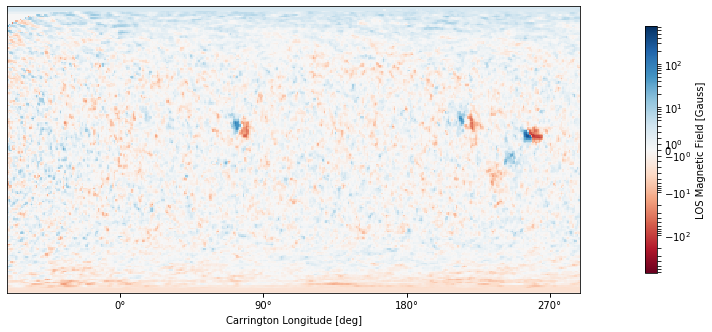

In [133]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca(projection=synmap)

# Plot the image
im = synmap.plot(cmap='RdBu',norm=matplotlib.colors.SymLogNorm(5,vmin=-7.5e2,vmax=7.5e2),annotate=False)

# Set up the Sine Latitude Grid
x = ax.coords[0]
y = ax.coords[1]

x.set_coord_type('longitude', coord_wrap=360.)
y.set_coord_type('latitude')

x.set_major_formatter('dd')
y.set_major_formatter('dd')

x.set_axislabel("Carrington Longitude [deg]")
y.set_axislabel("Latitude [deg]")

x.set_ticks(color='black', exclude_overlapping=True)
y.set_ticks(color='black', exclude_overlapping=True)

# Hide the grid
ax.coords.grid(alpha=0)

# Create a colorbar
cb = plt.colorbar(im, fraction=0.019, pad=0.1)
cb.set_label("LOS Magnetic Field [Gauss]")

# Another horrible hack to make the ticks draw on the RHS
#ax.set_ylim((1, synmap.data.shape[0] - 1))
plt.tight_layout()
fig.savefig('foo.png',bbox_inches='tight')

In [101]:
synmap.top_right_coord

<SkyCoord (HeliographicCarrington: obstime=2019-02-14 00:00:00): (lon, lat, radius) in (deg, deg, km)
    (nan, nan, 695508.)>

In [5]:
synmap_resample = synmap.resample([360,144]*u.pixel,method='nearest')
tmp_data = synmap_resample.data
tmp_data[0,:] = tmp_data[1,:]
tmp_data[-1,:] = tmp_data[-2,:]
synmap_resample = Map(tmp_data, synmap_resample.meta)

In [119]:
synmap.meta['cdelt2']

0.636619135747809

In [56]:
pfss_input = pfsspy.Input(synmap.data - synmap.data.mean(), 60, 2.5)

In [57]:
pfss_output = pfsspy.pfss(pfss_input)

Text(0.5, 1.0, 'Source surface magnetic field')

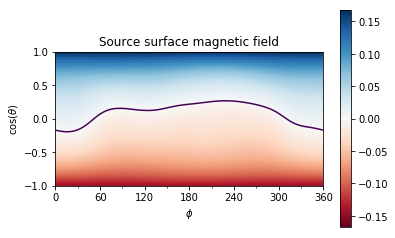

In [58]:
fig, ax = plt.subplots()
mesh = pfss_output.plot_source_surface(ax)
fig.colorbar(mesh)
pfss_output.plot_pil(ax)
ax.set_title('Source surface magnetic field')

In [112]:
lines = []
r = 1.01
for theta in np.linspace(0, np.pi, 25):
    for phi in np.linspace(0, 2 * np.pi, 25):
        x0 = np.array([r * np.cos(phi),
                       r * np.sin(theta) * np.sin(phi),
                       r * np.cos(theta) * np.sin(phi)])
        field_line = pfss_output.trace(x0, )
        lines.append(field_line)

In [113]:
lines_new = [SkyCoord(l,obstime=astropy.time.Time(synmap.date).iso) for l in lines]

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/sit

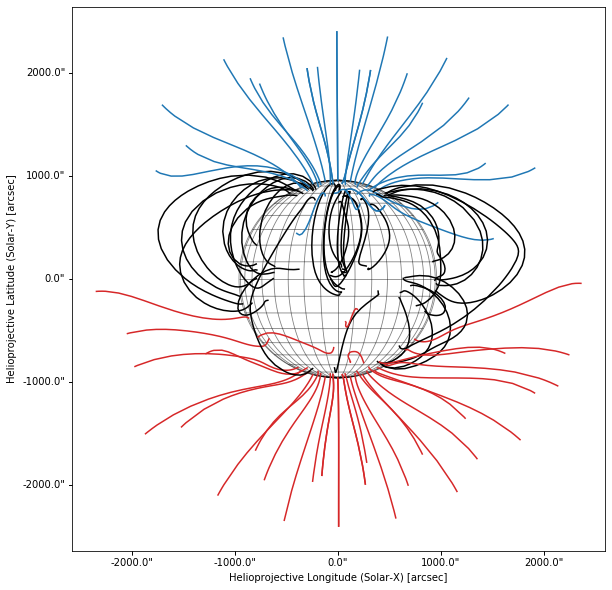

In [118]:
data = np.ones((10, 10))
lon,lat = 0*u.deg,0*u.deg
time_now = astropy.time.Time(synmap.date)
meta = {
    'ctype1': 'HPLN-TAN',
    'ctype2': 'HPLT-TAN',
    'cunit1': 'arcsec',
    'cunit2': 'arcsec',
    'crpix1': (data.shape[0] + 1)/2.,
    'crpix2': (data.shape[1] + 1)/2.,
    'cdelt1': 1.0,
    'cdelt2': 1.0,
    'crval1': 0.0,
    'crval2': 0.0,
    'hgln_obs': lon.to(u.deg).value,
    'hglt_obs': lat.to(u.deg).value,
    'dsun_obs': const.au.to(u.m).value,
    'dsun_ref': const.au.to(u.m).value,
    'rsun_ref': const.R_sun.to(u.m).value,
    'rsun_obs': ((const.R_sun/const.au).decompose()*u.radian).to(u.arcsec).value,
    't_obs': time_now.iso,
    'date-obs': time_now.iso,
}
dummy_map = GenericMap(data, meta)
# Plot coordinates
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=dummy_map)
dummy_map.plot(alpha=0, extent=[-1000, 1000, -1000, 1000], title=False, axes=ax)
for coord in lines_new:
    r = coord.transform_to(HeliographicStonyhurst).radius
    if r.max() < 1.25*const.R_sun:
        continue
    if np.abs(r[0] - r[-1]) < r[0] * 0.1:
        color='k'
    else:
        if r[0] - r[-1] > 0:
            color='C3'
        else:
            color='C0'
    ax.plot_coord(coord.transform_to(dummy_map.coordinate_frame), color=color)
dummy_map.draw_grid(axes=ax, grid_spacing=10*u.deg, color='k')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x1c2120f048>)

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/sit

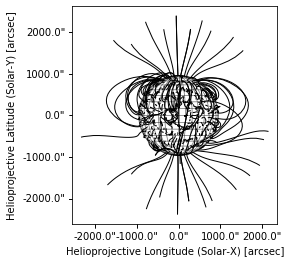

In [54]:
plot_fieldlines(*lines_new,obstime=astropy.time.Time(synmap.date),plot_kwargs={'color':'k','lw':1})

In [102]:
lines_new[0].transform_to(HeliographicStonyhurst)

<SkyCoord (HeliographicStonyhurst: obstime=2019-02-14 00:00:00): (lon, lat, radius) in (deg, deg, m)
    [(11.68200132,  0.25670828, 6.95700000e+08),
     (11.67833448,  0.25560378, 6.95762114e+08),
     (11.67247308,  0.25383708, 6.95860855e+08),
     (11.66657   ,  0.25205544, 6.95959181e+08),
     (11.66062512,  0.25025873, 6.96057086e+08),
     (11.63642024,  0.24291729, 6.96444289e+08),
     (11.42759906,  0.17735675, 6.99128235e+08),
     (11.18156463,  0.09495093, 7.01178400e+08),
     (11.05008274,  0.04943995, 7.02021903e+08),
     (10.91251672,  0.        , 7.02657000e+08),
     (10.91251672,  0.        , 7.02657000e+08),
     (10.77597286, -0.05832833, 7.02959627e+08),
     (10.64120088, -0.12385967, 7.03125259e+08),
     (10.37917224, -0.26607502, 7.03011234e+08),
     (10.14359928, -0.41347785, 7.01781555e+08),
     ( 9.95250928, -0.52753503, 6.99382669e+08),
     ( 9.80665681, -0.60282145, 6.96296926e+08),
     ( 9.79087232, -0.61097985, 6.95875458e+08),
     ( 9.78448987

Text(0, 0.5, 'The quick brown fox $\\Upsilon$')

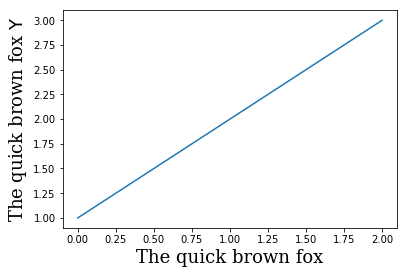

In [333]:
plt.plot([1,2,3])
plt.xlabel(r'The quick brown fox',fontsize=18,fontname='Palatino',fontfamily='serif')
plt.ylabel(r'The quick brown fox $\Upsilon$',fontsize=18,fontname='Palatino',fontfamily='serif')

In [337]:
matplotlib.get_cachedir()

'/Users/willbarnes/.matplotlib'